In [1]:
!nvidia-smi

Sun Apr 16 12:49:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:B3:00.0 Off |                  Off |
| N/A   38C    P0   152W / 300W |   2271MiB / 32768MiB |     31%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import sys
sys.path.append('/home/fastmri2/.conda/envs/snumvi/lib/python3.8/site-packages')

import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import nibabel as nib

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

MONAI version: 1.1.0
Numpy version: 1.24.2
Pytorch version: 1.9.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/fastmri8/.local/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.17.2
Pillow version: 8.0.1
Tensorboard version: 2.4.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.0+cu111
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.7.2
pandas version: 1.1.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#insta

In [4]:
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
data_dir = "cropped/HBP/"
uncropped_dir = "nifti/HBP"

In [5]:
patients = sorted(glob.glob(os.path.join(uncropped_dir, "*.nii.gz")))
print(len(patients))

244


In [6]:
patient_data = pd.read_excel("nifti_center.xlsx").set_index("patID")
print(patient_data)

        front  end  left  right  top  bottom  v_center  h_center  l_center
patID                                                                     
7739      102  199   185    117   45      45     111.5     194.0      50.0
20491     112  184   174    119   74      12     124.0     187.5      81.0
50368      80  227   180    127   71      22      86.5     186.5      74.5
59047     151  342   271    225   63      15     160.5     279.0      66.0
63193     116  191   170    137   70      23     122.5     176.5      73.5
...       ...  ...   ...    ...  ...     ...       ...       ...       ...
100139     85  213   140    157   48      40      96.0     151.5      54.0
100140     77  255   137    116   50      30     103.0     160.5      62.0
100157     64  221   172    115   66      15      81.5     188.5      75.5
100158    182  176    78    197   73      20     195.0      90.5      78.5
100164    108  186   219     77   43      43     121.0     231.0      50.0

[246 rows x 9 columns]


In [7]:
def crop_nifti(input_file, output_dir, centre_coords, crop_size):
    image = nib.load(input_file)
    image_data = image.get_fdata()
    padding = tuple((crop, crop) for crop in crop_size)
    image_data = np.pad(image_data, padding, 'constant', constant_values=0)
    padded_center = tuple(centre + crop for centre, crop in zip(centre_coords, crop_size))
    start_coords = tuple(int(center - 0.5 * crop) for center, crop in zip(padded_center, crop_size))
    end_coords = tuple(start + crop for start, crop in zip(start_coords, crop_size))
    cropped_data = image_data[start_coords[0]:end_coords[0],
                              start_coords[1]:end_coords[1],
                              start_coords[2]:end_coords[2]]
    cropped_img = nib.Nifti1Image(cropped_data, image.affine, image.header)
    output_path = os.path.join(output_dir, ''.join(map(str, crop_size)), input_file.split('/')[-1])
    nib.save(cropped_img, output_path)
    print("Saved as", output_path)

In [8]:
%%time
!mkdir cropped/HBP/13013065
crop_size = (130, 130, 65)

for patient in patients:
    patient_int = int(os.path.basename(patient).split('.')[0])
    crop_nifti(patient, data_dir, tuple(patient_data.loc[patient_int, "v_center":"l_center"]), crop_size)

Saved as cropped/HBP/13013065/0007739.nii.gz
Saved as cropped/HBP/13013065/0020491.nii.gz
Saved as cropped/HBP/13013065/0050368.nii.gz
Saved as cropped/HBP/13013065/0059047.nii.gz
Saved as cropped/HBP/13013065/0063193.nii.gz
Saved as cropped/HBP/13013065/0066509.nii.gz
Saved as cropped/HBP/13013065/0074922.nii.gz
Saved as cropped/HBP/13013065/0085260.nii.gz
Saved as cropped/HBP/13013065/0085262.nii.gz
Saved as cropped/HBP/13013065/0085265.nii.gz
Saved as cropped/HBP/13013065/0085266.nii.gz
Saved as cropped/HBP/13013065/0085268.nii.gz
Saved as cropped/HBP/13013065/0085269.nii.gz
Saved as cropped/HBP/13013065/0085287.nii.gz
Saved as cropped/HBP/13013065/0085288.nii.gz
Saved as cropped/HBP/13013065/0085289.nii.gz
Saved as cropped/HBP/13013065/0085298.nii.gz
Saved as cropped/HBP/13013065/0085299.nii.gz
Saved as cropped/HBP/13013065/0085300.nii.gz
Saved as cropped/HBP/13013065/0085301.nii.gz
Saved as cropped/HBP/13013065/0085303.nii.gz
Saved as cropped/HBP/13013065/0085310.nii.gz
Saved as c

In [9]:
new_data_dir = os.path.join(data_dir, ''.join(map(str, crop_size)))
new_patients = sorted(glob.glob(os.path.join(new_data_dir, "*.nii.gz")))
print(len(new_patients))

244


In [10]:
def nii_loader(filename) :
    nimg = nib.load(filename)
    return nimg.get_fdata() , nimg.affine, nimg.header

def visualize_all(dataset, cols, idxs, target_layer=10):
    import random
    fig = plt.figure()
    rows = len(idxs)//cols + 1
    i = 1
    for idx in idxs:
        image = dataset[idx]
        print(idx + 1, image)
        image_data, image_affine, image_header = nii_loader(image)
        target_image = image_data[:,:,target_layer]
        sub_fig = fig.add_subplot(rows, cols, i)
        sub_fig.get_xaxis().set_visible(False)
        sub_fig.get_yaxis().set_visible(False)
        sub_fig.imshow(target_image, cmap='gray')
        i += 1
    plt.show()

1 cropped/HBP/13013065/0007739.nii.gz
2 cropped/HBP/13013065/0020491.nii.gz
3 cropped/HBP/13013065/0050368.nii.gz
4 cropped/HBP/13013065/0059047.nii.gz
5 cropped/HBP/13013065/0063193.nii.gz
6 cropped/HBP/13013065/0066509.nii.gz
7 cropped/HBP/13013065/0074922.nii.gz
8 cropped/HBP/13013065/0085260.nii.gz
9 cropped/HBP/13013065/0085262.nii.gz
10 cropped/HBP/13013065/0085265.nii.gz
11 cropped/HBP/13013065/0085266.nii.gz
12 cropped/HBP/13013065/0085268.nii.gz
13 cropped/HBP/13013065/0085269.nii.gz
14 cropped/HBP/13013065/0085287.nii.gz
15 cropped/HBP/13013065/0085288.nii.gz
16 cropped/HBP/13013065/0085289.nii.gz
17 cropped/HBP/13013065/0085298.nii.gz
18 cropped/HBP/13013065/0085299.nii.gz
19 cropped/HBP/13013065/0085300.nii.gz
20 cropped/HBP/13013065/0085301.nii.gz
21 cropped/HBP/13013065/0085303.nii.gz
22 cropped/HBP/13013065/0085310.nii.gz
23 cropped/HBP/13013065/0085313.nii.gz
24 cropped/HBP/13013065/0085314.nii.gz
25 cropped/HBP/13013065/0085317.nii.gz
26 cropped/HBP/13013065/0085319.ni

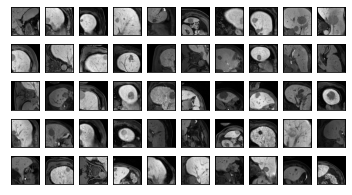

In [11]:
visualize_all(new_patients, 10, list(range(0, 50)), target_layer=crop_size[2]//2)

51 cropped/HBP/13013065/0099653.nii.gz
52 cropped/HBP/13013065/0099654.nii.gz
53 cropped/HBP/13013065/0099655.nii.gz
54 cropped/HBP/13013065/0099656.nii.gz
55 cropped/HBP/13013065/0099657.nii.gz
56 cropped/HBP/13013065/0099658.nii.gz
57 cropped/HBP/13013065/0099659.nii.gz
58 cropped/HBP/13013065/0099660.nii.gz
59 cropped/HBP/13013065/0099661.nii.gz
60 cropped/HBP/13013065/0099662.nii.gz
61 cropped/HBP/13013065/0099663.nii.gz
62 cropped/HBP/13013065/0099664.nii.gz
63 cropped/HBP/13013065/0099668.nii.gz
64 cropped/HBP/13013065/0099669.nii.gz
65 cropped/HBP/13013065/0099670.nii.gz
66 cropped/HBP/13013065/0099672.nii.gz
67 cropped/HBP/13013065/0099674.nii.gz
68 cropped/HBP/13013065/0099675.nii.gz
69 cropped/HBP/13013065/0099677.nii.gz
70 cropped/HBP/13013065/0099681.nii.gz
71 cropped/HBP/13013065/0099683.nii.gz
72 cropped/HBP/13013065/0099684.nii.gz
73 cropped/HBP/13013065/0099688.nii.gz
74 cropped/HBP/13013065/0099689.nii.gz
75 cropped/HBP/13013065/0099690.nii.gz
76 cropped/HBP/13013065/0

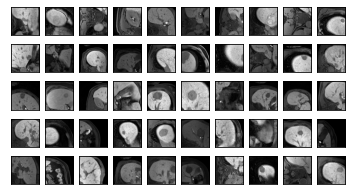

In [12]:
visualize_all(new_patients, 10, list(range(50, 100)), target_layer=crop_size[2]//2)

101 cropped/HBP/13013065/0099749.nii.gz
102 cropped/HBP/13013065/0099752.nii.gz
103 cropped/HBP/13013065/0099753.nii.gz
104 cropped/HBP/13013065/0099755.nii.gz
105 cropped/HBP/13013065/0099757.nii.gz
106 cropped/HBP/13013065/0099762.nii.gz
107 cropped/HBP/13013065/0099767.nii.gz
108 cropped/HBP/13013065/0099768.nii.gz
109 cropped/HBP/13013065/0099769.nii.gz
110 cropped/HBP/13013065/0099773.nii.gz
111 cropped/HBP/13013065/0099775.nii.gz
112 cropped/HBP/13013065/0099776.nii.gz
113 cropped/HBP/13013065/0099777.nii.gz
114 cropped/HBP/13013065/0099780.nii.gz
115 cropped/HBP/13013065/0099781.nii.gz
116 cropped/HBP/13013065/0099782.nii.gz
117 cropped/HBP/13013065/0099784.nii.gz
118 cropped/HBP/13013065/0099785.nii.gz
119 cropped/HBP/13013065/0099786.nii.gz
120 cropped/HBP/13013065/0099787.nii.gz
121 cropped/HBP/13013065/0099790.nii.gz
122 cropped/HBP/13013065/0099791.nii.gz
123 cropped/HBP/13013065/0099793.nii.gz
124 cropped/HBP/13013065/0099794.nii.gz
125 cropped/HBP/13013065/0099795.nii.gz


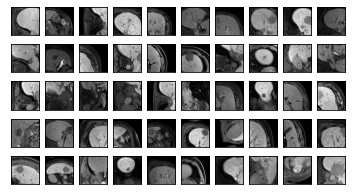

In [13]:
visualize_all(new_patients, 10, list(range(100, 150)), target_layer=crop_size[2]//2)

151 cropped/HBP/13013065/0099994.nii.gz
152 cropped/HBP/13013065/0099995.nii.gz
153 cropped/HBP/13013065/0099996.nii.gz
154 cropped/HBP/13013065/0099997.nii.gz
155 cropped/HBP/13013065/0099998.nii.gz
156 cropped/HBP/13013065/0100000.nii.gz
157 cropped/HBP/13013065/0100001.nii.gz
158 cropped/HBP/13013065/0100002.nii.gz
159 cropped/HBP/13013065/0100003.nii.gz
160 cropped/HBP/13013065/0100005.nii.gz
161 cropped/HBP/13013065/0100006.nii.gz
162 cropped/HBP/13013065/0100007.nii.gz
163 cropped/HBP/13013065/0100008.nii.gz
164 cropped/HBP/13013065/0100010.nii.gz
165 cropped/HBP/13013065/0100011.nii.gz
166 cropped/HBP/13013065/0100012.nii.gz
167 cropped/HBP/13013065/0100013.nii.gz
168 cropped/HBP/13013065/0100017.nii.gz
169 cropped/HBP/13013065/0100019.nii.gz
170 cropped/HBP/13013065/0100020.nii.gz
171 cropped/HBP/13013065/0100022.nii.gz
172 cropped/HBP/13013065/0100023.nii.gz
173 cropped/HBP/13013065/0100029.nii.gz
174 cropped/HBP/13013065/0100031.nii.gz
175 cropped/HBP/13013065/0100032.nii.gz


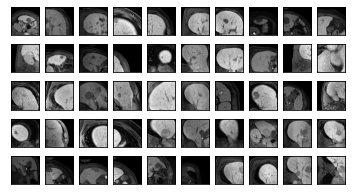

In [14]:
visualize_all(new_patients, 10, list(range(150, 200)), target_layer=crop_size[2]//2)

In [ ]:
visualize_all(new_patients, 10, list(range(200, 244)), target_layer=crop_size[2]//2)